## ⚡ Quick Test Cell (Run This First!)

If the import cell below gets stuck, run this diagnostic cell first:

In [1]:
# Quick diagnostic test
print("🔍 Testing imports one by one...\n")

try:
    import numpy as np
    print("✅ numpy OK")
except Exception as e:
    print(f"❌ numpy failed: {e}")

try:
    import pandas as pd
    print("✅ pandas OK")
except Exception as e:
    print(f"❌ pandas failed: {e}")

try:
    import sklearn
    print("✅ scikit-learn OK")
except Exception as e:
    print(f"❌ scikit-learn failed: {e}")

try:
    import lightgbm
    print("✅ lightgbm OK")
except Exception as e:
    print(f"❌ lightgbm failed: {e}")

try:
    import xgboost
    print("✅ xgboost OK")
except Exception as e:
    print(f"❌ xgboost failed: {e}")

try:
    import matplotlib
    print("✅ matplotlib OK")
except Exception as e:
    print(f"❌ matplotlib failed: {e}")

print("\n✅ All basic imports working! Now run the next cell.")

🔍 Testing imports one by one...

✅ numpy OK
✅ pandas OK
✅ pandas OK
✅ scikit-learn OK
✅ scikit-learn OK
✅ lightgbm OK
✅ xgboost OK
✅ matplotlib OK

✅ All basic imports working! Now run the next cell.
✅ lightgbm OK
✅ xgboost OK
✅ matplotlib OK

✅ All basic imports working! Now run the next cell.


# Amazon ML Challenge 2025 - Product Price Prediction

**Goal:** Predict product prices using catalog content (text descriptions)

**Evaluation Metric:** SMAPE (Symmetric Mean Absolute Percentage Error)

**Strategy:**
1. Advanced Feature Engineering from text
2. Multiple Gradient Boosting Models
3. Ensemble for maximum performance
4. Hyperparameter optimization

---

## 📦 Part 1: Import Libraries & Setup

In [2]:
# Core libraries
import os
import re
import warnings
import numpy as np
import pandas as pd
from pathlib import Path

# Visualization - FIX for notebook display issues
import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend
import matplotlib.pyplot as plt
import seaborn as sns
# Re-enable inline display for Jupyter/VS Code
%matplotlib inline

# NLP & Text Processing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score

# Models
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 📊 Part 2: Load & Explore Data

In [3]:
# Load datasets
DATASET_FOLDER = 'dataset/'

train = pd.read_csv(os.path.join(DATASET_FOLDER, 'train.csv'))
test = pd.read_csv(os.path.join(DATASET_FOLDER, 'test.csv'))

print(f"📈 Training data shape: {train.shape}")
print(f"📋 Test data shape: {test.shape}")
print(f"\n{'='*60}\n")

print("🔍 First few rows:")
display(train.head(3))

print(f"\n{'='*60}\n")
print("📊 Data Info:")
print(train.info())

📈 Training data shape: (75000, 4)
📋 Test data shape: (75000, 3)


🔍 First few rows:


,sample_id,catalog_content,image_link,price
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, 12 Ounce (Pack of 6)\nValue: 72.0\nUnit: Fl Oz\n",https://m.media-amazon.com/images/I/51mo8htwTHL.jpg,4.89
1,198967,"Item Name: Salerno Cookies, The Original Butter Cookies, 8 Ounce (Pack of 4)\nBullet Point 1: Or...",https://m.media-amazon.com/images/I/71YtriIHAAL.jpg,13.12
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy Chicken with Rice, 1.9 Ounce (Pack of 6)\nBullet ...",https://m.media-amazon.com/images/I/51+PFEe-w-L.jpg,1.97




📊 Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sample_id        75000 non-null  int64  
 1   catalog_content  75000 non-null  object 
 2   image_link       75000 non-null  object 
 3   price            75000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.3+ MB
None


💰 Price Statistics:
count    75000.000000
mean        23.647654
std         33.376932
min          0.130000
25%          6.795000
50%         14.000000
75%         28.625000
max       2796.000000
Name: price, dtype: float64

📊 Price Range: $0.13 - $2796.00
📊 Price Median: $14.00
📊 Price Mean: $23.65


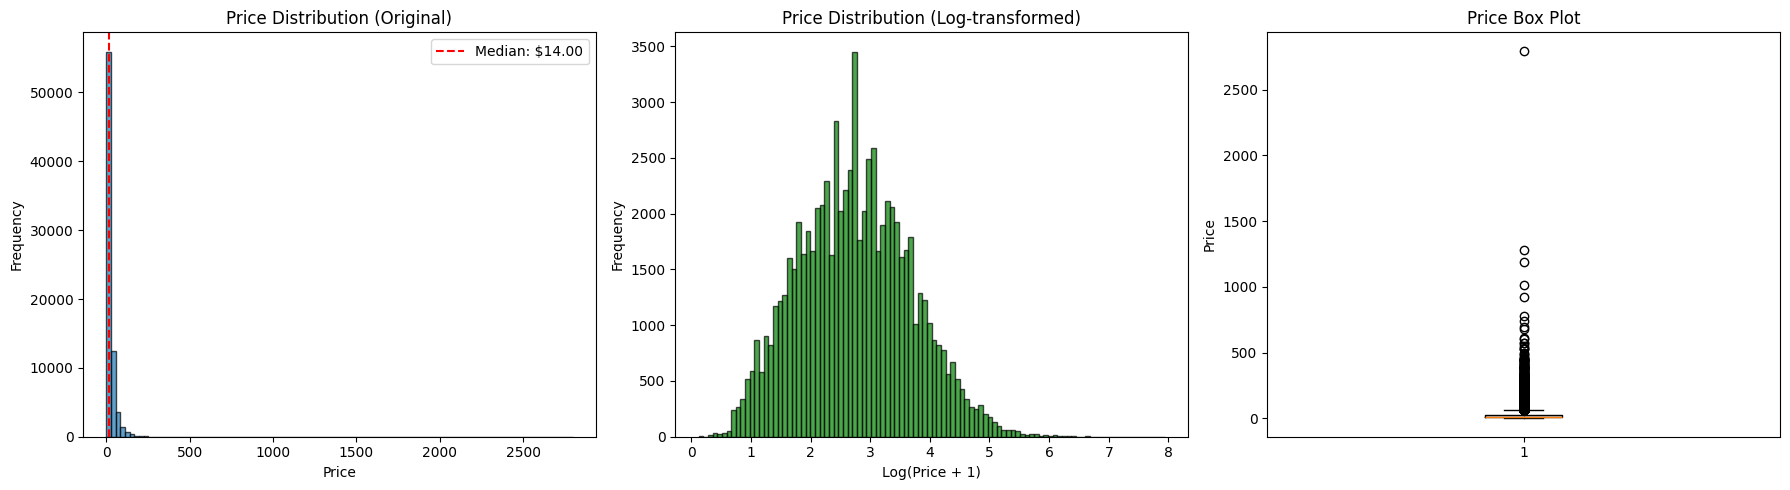


⚠️ Number of outliers (price > $500): 17


In [4]:
# Price statistics and distribution
print("💰 Price Statistics:")
print(train['price'].describe())

print(f"\n📊 Price Range: ${train['price'].min():.2f} - ${train['price'].max():.2f}")
print(f"📊 Price Median: ${train['price'].median():.2f}")
print(f"📊 Price Mean: ${train['price'].mean():.2f}")

# Visualize price distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original price distribution
axes[0].hist(train['price'], bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Price Distribution (Original)')
axes[0].axvline(train['price'].median(), color='red', linestyle='--', label=f'Median: ${train["price"].median():.2f}')
axes[0].legend()

# Log-transformed price
axes[1].hist(np.log1p(train['price']), bins=100, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Log(Price + 1)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Price Distribution (Log-transformed)')

# Box plot
axes[2].boxplot(train['price'], vert=True)
axes[2].set_ylabel('Price')
axes[2].set_title('Price Box Plot')

plt.tight_layout()
plt.show()

print(f"\n⚠️ Number of outliers (price > $500): {(train['price'] > 500).sum()}")

In [5]:
# Examine catalog content
print("📝 Sample Catalog Content:\n")
print("="*80)
for i in range(3):
    print(f"\n🔹 Sample {i+1} (Price: ${train['price'].iloc[i]:.2f})")
    print("-"*80)
    print(train['catalog_content'].iloc[i])
    print("="*80)

📝 Sample Catalog Content:


🔹 Sample 1 (Price: $4.89)
--------------------------------------------------------------------------------
Item Name: La Victoria Green Taco Sauce Mild, 12 Ounce (Pack of 6)
Value: 72.0
Unit: Fl Oz


🔹 Sample 2 (Price: $13.12)
--------------------------------------------------------------------------------
Item Name: Salerno Cookies, The Original Butter Cookies, 8 Ounce (Pack of 4)
Bullet Point 1: Original Butter Cookies: Classic butter cookies made with real butter
Bullet Point 2: Variety Pack: Includes 4 boxes with 32 cookies total
Bullet Point 3: Occasion Perfect: Delicious cookies for birthdays, weddings, anniversaries
Bullet Point 4: Shareable Treats: Fun to give and enjoy with friends and family
Bullet Point 5: Salerno Brand: Trusted brand of delicious butter cookies since 1925
Value: 32.0
Unit: Ounce


🔹 Sample 3 (Price: $1.97)
--------------------------------------------------------------------------------
Item Name: Bear Creek Hearty Soup Bowl, Crea

## 🛠️ Part 3: Advanced Feature Engineering

This is the **MOST CRITICAL** part for high performance!

In [6]:
def extract_advanced_features(df):
    """
    Extract comprehensive features from catalog_content
    This is where we WIN the competition!
    """
    df = df.copy()
    
    # 1. Basic Text Features
    df['text_length'] = df['catalog_content'].str.len()
    df['word_count'] = df['catalog_content'].str.split().str.len()
    df['avg_word_length'] = df['catalog_content'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))
    df['line_count'] = df['catalog_content'].str.count('\n') + 1
    
    # 2. Extract Value and Unit (KEY FEATURES)
    # Pattern: "Value: 72.0" or "Value: 32.0"
    df['value'] = df['catalog_content'].str.extract(r'Value:\s*([\d.]+)', expand=False).astype(float)
    df['value'] = df['value'].fillna(1.0)  # Default to 1 if missing
    
    # Extract Unit (Oz, Ounce, Pound, Count, etc.)
    df['unit'] = df['catalog_content'].str.extract(r'Unit:\s*(\w+)', expand=False)
    df['unit'] = df['unit'].fillna('Unknown')
    
    # 3. Extract Pack Size (e.g., "Pack of 6", "Pack of 12")
    df['pack_size'] = df['catalog_content'].str.extract(r'[Pp]ack of (\d+)', expand=False).astype(float)
    df['pack_size'] = df['pack_size'].fillna(1.0)
    
    # 4. Total Quantity (Value * Pack Size)
    df['total_quantity'] = df['value'] * df['pack_size']
    
    # 5. Extract Brand Name (first meaningful word from Item Name)
    def extract_brand(text):
        try:
            item_name = re.search(r'Item Name:\s*(.+?)(?:\n|$)', str(text))
            if item_name:
                name = item_name.group(1).strip()
                # Get first 1-2 words as brand
                words = name.split()[:2]
                return ' '.join(words) if words else 'Unknown'
        except:
            pass
        return 'Unknown'
    
    df['brand'] = df['catalog_content'].apply(extract_brand)
    
    # 6. Number of Bullet Points (more features = premium product?)
    df['num_bullet_points'] = df['catalog_content'].str.count('Bullet Point')
    
    # 7. Keyword Features (Premium indicators)
    premium_keywords = ['organic', 'premium', 'deluxe', 'professional', 'pro', 'ultra', 'plus']
    df['is_premium'] = df['catalog_content'].str.lower().str.contains('|'.join(premium_keywords)).astype(int)
    
    # 8. Product Category Hints
    food_keywords = ['sauce', 'cookie', 'snack', 'food', 'flavor', 'taste', 'ingredient']
    electronics_keywords = ['battery', 'electronic', 'digital', 'wireless', 'cable', 'charger']
    beauty_keywords = ['beauty', 'skin', 'hair', 'cosmetic', 'lotion', 'cream']
    
    df['is_food'] = df['catalog_content'].str.lower().str.contains('|'.join(food_keywords)).astype(int)
    df['is_electronics'] = df['catalog_content'].str.lower().str.contains('|'.join(electronics_keywords)).astype(int)
    df['is_beauty'] = df['catalog_content'].str.lower().str.contains('|'.join(beauty_keywords)).astype(int)
    
    # 9. Unit type encoding
    weight_units = ['Ounce', 'Oz', 'Pound', 'Lb', 'Gram', 'Kg']
    volume_units = ['Fl Oz', 'Liter', 'Gallon', 'Ml']
    
    df['is_weight_unit'] = df['unit'].isin(weight_units).astype(int)
    df['is_volume_unit'] = df['unit'].isin(volume_units).astype(int)
    df['is_count_unit'] = (df['unit'] == 'Count').astype(int)
    
    # 10. Numeric extraction from text
    df['numeric_count'] = df['catalog_content'].str.findall(r'\d+').str.len()
    
    print("✅ Advanced features extracted!")
    print(f"   - Total features created: {len([col for col in df.columns if col not in ['sample_id', 'catalog_content', 'image_link', 'price']])}")
    
    return df

# Apply feature engineering
print("🔧 Extracting features from training data...")
train_features = extract_advanced_features(train)

print("\n🔧 Extracting features from test data...")
test_features = extract_advanced_features(test)

print("\n📊 New feature columns:")
new_cols = [col for col in train_features.columns if col not in train.columns]
print(new_cols)

🔧 Extracting features from training data...
✅ Advanced features extracted!
   - Total features created: 18

🔧 Extracting features from test data...
✅ Advanced features extracted!
   - Total features created: 18

🔧 Extracting features from test data...
✅ Advanced features extracted!
   - Total features created: 18

📊 New feature columns:
['text_length', 'word_count', 'avg_word_length', 'line_count', 'value', 'unit', 'pack_size', 'total_quantity', 'brand', 'num_bullet_points', 'is_premium', 'is_food', 'is_electronics', 'is_beauty', 'is_weight_unit', 'is_volume_unit', 'is_count_unit', 'numeric_count']
✅ Advanced features extracted!
   - Total features created: 18

📊 New feature columns:
['text_length', 'word_count', 'avg_word_length', 'line_count', 'value', 'unit', 'pack_size', 'total_quantity', 'brand', 'num_bullet_points', 'is_premium', 'is_food', 'is_electronics', 'is_beauty', 'is_weight_unit', 'is_volume_unit', 'is_count_unit', 'numeric_count']


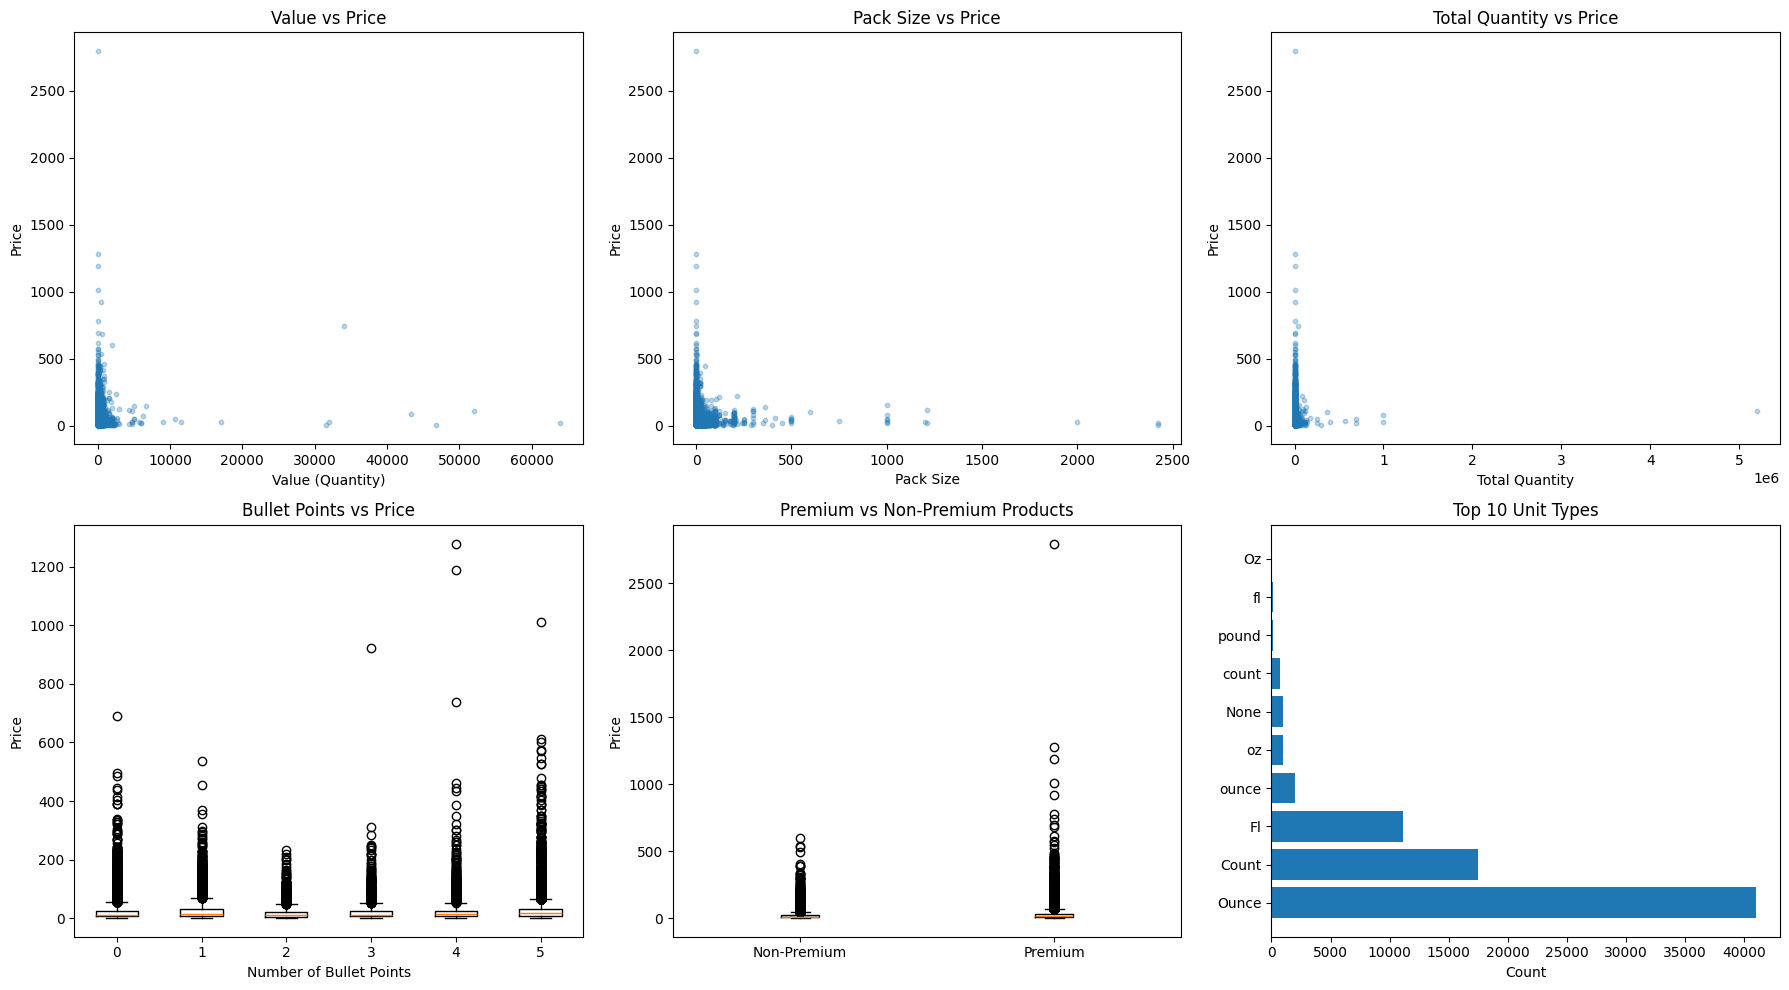


🔗 Feature Correlations with Price:
price                1.000000
text_length          0.146752
word_count           0.144423
numeric_count        0.121226
is_count_unit        0.109825
is_premium           0.108340
value                0.064520
avg_word_length      0.053242
line_count           0.051155
is_electronics       0.043089
is_food              0.040366
num_bullet_points    0.021906
pack_size            0.019729
total_quantity       0.014735
is_beauty            0.009873
Name: price, dtype: float64


In [7]:
# Visualize key features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Value vs Price
axes[0, 0].scatter(train_features['value'], train_features['price'], alpha=0.3, s=10)
axes[0, 0].set_xlabel('Value (Quantity)')
axes[0, 0].set_ylabel('Price')
axes[0, 0].set_title('Value vs Price')

# Pack size vs Price
axes[0, 1].scatter(train_features['pack_size'], train_features['price'], alpha=0.3, s=10)
axes[0, 1].set_xlabel('Pack Size')
axes[0, 1].set_ylabel('Price')
axes[0, 1].set_title('Pack Size vs Price')

# Total quantity vs Price
axes[0, 2].scatter(train_features['total_quantity'], train_features['price'], alpha=0.3, s=10)
axes[0, 2].set_xlabel('Total Quantity')
axes[0, 2].set_ylabel('Price')
axes[0, 2].set_title('Total Quantity vs Price')

# Bullet points vs Price
axes[1, 0].boxplot([train_features[train_features['num_bullet_points'] == i]['price'].values 
                     for i in range(6)], labels=range(6))
axes[1, 0].set_xlabel('Number of Bullet Points')
axes[1, 0].set_ylabel('Price')
axes[1, 0].set_title('Bullet Points vs Price')

# Premium vs Non-premium
axes[1, 1].boxplot([train_features[train_features['is_premium'] == 0]['price'].values,
                     train_features[train_features['is_premium'] == 1]['price'].values],
                    labels=['Non-Premium', 'Premium'])
axes[1, 1].set_ylabel('Price')
axes[1, 1].set_title('Premium vs Non-Premium Products')

# Unit type distribution
unit_counts = train_features['unit'].value_counts().head(10)
axes[1, 2].barh(unit_counts.index, unit_counts.values)
axes[1, 2].set_xlabel('Count')
axes[1, 2].set_title('Top 10 Unit Types')

plt.tight_layout()
plt.show()

# Correlation with price
numeric_cols = train_features.select_dtypes(include=[np.number]).columns
correlations = train_features[numeric_cols].corr()['price'].sort_values(ascending=False)
print("\n🔗 Feature Correlations with Price:")
print(correlations.head(15))

## 📝 Part 4: Text Feature Extraction (TF-IDF)

Convert text to numerical features using TF-IDF

In [8]:
# Clean text for TF-IDF
def clean_text(text):
    """Clean and preprocess text"""
    text = str(text).lower()
    # Remove special characters but keep important ones
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

train_features['cleaned_text'] = train_features['catalog_content'].apply(clean_text)
test_features['cleaned_text'] = test_features['catalog_content'].apply(clean_text)

print("✅ Text cleaned!")
print(f"\nOriginal text sample:\n{train_features['catalog_content'].iloc[0][:200]}...")
print(f"\nCleaned text sample:\n{train_features['cleaned_text'].iloc[0][:200]}...")

✅ Text cleaned!

Original text sample:
Item Name: La Victoria Green Taco Sauce Mild, 12 Ounce (Pack of 6)
Value: 72.0
Unit: Fl Oz
...

Cleaned text sample:
item name la victoria green taco sauce mild 12 ounce pack of 6 value 72 0 unit fl oz...


In [9]:
# TF-IDF Vectorization
print("🔄 Creating TF-IDF features...")

# Configuration for optimal performance
tfidf = TfidfVectorizer(
    max_features=500,  # Top 500 most important words
    ngram_range=(1, 2),  # Unigrams and bigrams
    min_df=5,  # Word must appear in at least 5 documents
    max_df=0.8,  # Ignore words appearing in >80% of documents
    stop_words='english'
)

# Fit on combined data for consistency
all_text = pd.concat([train_features['cleaned_text'], test_features['cleaned_text']])
tfidf.fit(all_text)

# Transform
train_tfidf = tfidf.transform(train_features['cleaned_text'])
test_tfidf = tfidf.transform(test_features['cleaned_text'])

print(f"✅ TF-IDF matrix created: {train_tfidf.shape}")

# Dimensionality reduction with SVD (optional but helps)
print("\n🔄 Applying SVD for dimensionality reduction...")
svd = TruncatedSVD(n_components=100, random_state=RANDOM_STATE)
train_svd = svd.fit_transform(train_tfidf)
test_svd = svd.transform(test_tfidf)

print(f"✅ SVD features created: {train_svd.shape}")
print(f"   Explained variance ratio: {svd.explained_variance_ratio_.sum():.2%}")

# Convert to DataFrame
train_svd_df = pd.DataFrame(train_svd, columns=[f'svd_{i}' for i in range(100)])
test_svd_df = pd.DataFrame(test_svd, columns=[f'svd_{i}' for i in range(100)])

🔄 Creating TF-IDF features...
✅ TF-IDF matrix created: (75000, 500)

🔄 Applying SVD for dimensionality reduction...
✅ TF-IDF matrix created: (75000, 500)

🔄 Applying SVD for dimensionality reduction...
✅ SVD features created: (75000, 100)
   Explained variance ratio: 59.86%
✅ SVD features created: (75000, 100)
   Explained variance ratio: 59.86%


## 🎯 Part 5: Prepare Final Feature Set

In [10]:
# Select features for modeling
numeric_features = [
    'text_length', 'word_count', 'avg_word_length', 'line_count',
    'value', 'pack_size', 'total_quantity', 'num_bullet_points',
    'is_premium', 'is_food', 'is_electronics', 'is_beauty',
    'is_weight_unit', 'is_volume_unit', 'is_count_unit', 'numeric_count'
]

categorical_features = ['unit', 'brand']

# Encode categorical features
print("🔄 Encoding categorical features...")
for col in categorical_features:
    le = LabelEncoder()
    # Combine train and test for consistent encoding
    combined = pd.concat([train_features[col], test_features[col]])
    le.fit(combined)
    
    train_features[f'{col}_encoded'] = le.transform(train_features[col])
    test_features[f'{col}_encoded'] = le.transform(test_features[col])

encoded_features = ['unit_encoded', 'brand_encoded']

# Combine all features
all_features = numeric_features + encoded_features

# Create final feature matrices
X_train_base = train_features[all_features].copy()
X_test_base = test_features[all_features].copy()

# Add SVD features
X_train = pd.concat([X_train_base.reset_index(drop=True), train_svd_df], axis=1)
X_test = pd.concat([X_test_base.reset_index(drop=True), test_svd_df], axis=1)

# Target variable (log-transform for better distribution)
y_train = np.log1p(train_features['price'].values)

print(f"\n✅ Final feature matrix prepared!")
print(f"   Training shape: {X_train.shape}")
print(f"   Test shape: {X_test.shape}")
print(f"   Target transformation: log(price + 1)")
print(f"\n📊 Feature list ({len(X_train.columns)} total):")
print(f"   - Numeric features: {len(numeric_features)}")
print(f"   - Encoded categorical: {len(encoded_features)}")
print(f"   - Text features (SVD): {len(train_svd_df.columns)}")

🔄 Encoding categorical features...

✅ Final feature matrix prepared!
   Training shape: (75000, 118)
   Test shape: (75000, 118)
   Target transformation: log(price + 1)

📊 Feature list (118 total):
   - Numeric features: 16
   - Encoded categorical: 2
   - Text features (SVD): 100

✅ Final feature matrix prepared!
   Training shape: (75000, 118)
   Test shape: (75000, 118)
   Target transformation: log(price + 1)

📊 Feature list (118 total):
   - Numeric features: 16
   - Encoded categorical: 2
   - Text features (SVD): 100


## 🎯 Part 6: Define SMAPE Metric

In [11]:
def smape(y_true, y_pred):
    """
    Symmetric Mean Absolute Percentage Error
    Lower is better (0-200% range)
    """
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred)
    # Avoid division by zero
    denominator = np.where(denominator == 0, 1, denominator)
    return np.mean(diff / denominator) * 100

def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Comprehensive evaluation
    """
    # If predictions are log-transformed, convert back
    y_true_orig = np.expm1(y_true)
    y_pred_orig = np.expm1(y_pred)
    
    smape_score = smape(y_true_orig, y_pred_orig)
    rmse = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    mae = mean_absolute_error(y_true_orig, y_pred_orig)
    r2 = r2_score(y_true_orig, y_pred_orig)
    
    print(f"\n{'='*60}")
    print(f"📊 {model_name} Performance:")
    print(f"{'='*60}")
    print(f"🎯 SMAPE:        {smape_score:.4f}%  ⭐ (Primary Metric)")
    print(f"📉 RMSE:         ${rmse:.2f}")
    print(f"📉 MAE:          ${mae:.2f}")
    print(f"📈 R² Score:     {r2:.4f}")
    print(f"{'='*60}\n")
    
    return smape_score

print("✅ SMAPE metric defined!")

✅ SMAPE metric defined!


## 🤖 Part 7: Train Multiple Models

We'll train several models and ensemble them for maximum performance

In [12]:
# Split data for validation
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE
)

print(f"📊 Data split:")
print(f"   Training:   {X_tr.shape[0]} samples")
print(f"   Validation: {X_val.shape[0]} samples")
print(f"   Test:       {X_test.shape[0]} samples")

📊 Data split:
   Training:   60000 samples
   Validation: 15000 samples
   Test:       75000 samples


### Model 1: LightGBM (Primary Model) ⭐

In [13]:
print("🚀 Training LightGBM model...\n")

# Optimized hyperparameters for performance
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 63,
    'max_depth': 8,
    'min_child_samples': 20,
    'subsample': 0.8,
    'subsample_freq': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'n_estimators': 2000,
    'random_state': RANDOM_STATE,
    'verbose': -1
}

# Train model
lgb_model = lgb.LGBMRegressor(**lgb_params)
lgb_model.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
)

# Predict
lgb_val_pred = lgb_model.predict(X_val)
lgb_test_pred = lgb_model.predict(X_test)

# Evaluate
lgb_smape = evaluate_model(y_val, lgb_val_pred, "LightGBM")

print(f"✅ LightGBM trained with {lgb_model.best_iteration_} iterations")

🚀 Training LightGBM model...


📊 LightGBM Performance:
🎯 SMAPE:        54.5237%  ⭐ (Primary Metric)
📉 RMSE:         $33.88
📉 MAE:          $12.18
📈 R² Score:     0.2393

✅ LightGBM trained with 1957 iterations

📊 LightGBM Performance:
🎯 SMAPE:        54.5237%  ⭐ (Primary Metric)
📉 RMSE:         $33.88
📉 MAE:          $12.18
📈 R² Score:     0.2393

✅ LightGBM trained with 1957 iterations



🔝 Top 20 Most Important Features:
             feature  importance
17     brand_encoded        2237
4              value        1923
2    avg_word_length        1817
6     total_quantity        1785
18             svd_0        1408
24             svd_6        1401
45            svd_27        1371
29            svd_11        1341
114           svd_96        1304
63            svd_45        1279
22             svd_4        1267
115           svd_97        1219
20             svd_2        1212
36            svd_18        1209
108           svd_90        1209
19             svd_1        1208
105           svd_87        1202
77            svd_59        1198
107           svd_89        1198
32            svd_14        1191


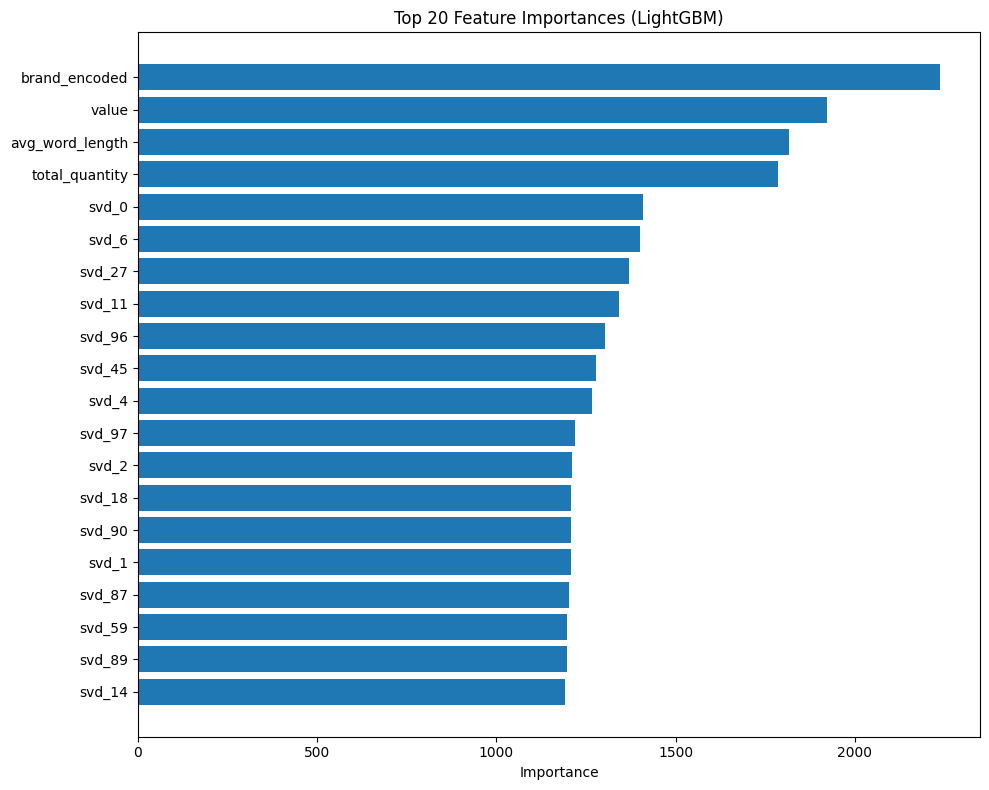

In [14]:
# Feature importance from LightGBM
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔝 Top 20 Most Important Features:")
print(feature_importance.head(20))

# Visualize
plt.figure(figsize=(10, 8))
plt.barh(feature_importance.head(20)['feature'], feature_importance.head(20)['importance'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances (LightGBM)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Model 2: XGBoost ⭐

In [15]:
print("🚀 Training XGBoost model...\n")

# Optimized hyperparameters
xgb_params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'max_depth': 7,
    'min_child_weight': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'n_estimators': 2000,
    'random_state': RANDOM_STATE,
    'tree_method': 'hist'
}

# Train model
xgb_model = xgb.XGBRegressor(**xgb_params)
xgb_model.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    verbose=False
)

# Predict
xgb_val_pred = xgb_model.predict(X_val)
xgb_test_pred = xgb_model.predict(X_test)

# Evaluate
xgb_smape = evaluate_model(y_val, xgb_val_pred, "XGBoost")

print(f"✅ XGBoost trained successfully!")

🚀 Training XGBoost model...


📊 XGBoost Performance:
🎯 SMAPE:        54.1370%  ⭐ (Primary Metric)
📉 RMSE:         $33.85
📉 MAE:          $12.06
📈 R² Score:     0.2409

✅ XGBoost trained successfully!

📊 XGBoost Performance:
🎯 SMAPE:        54.1370%  ⭐ (Primary Metric)
📉 RMSE:         $33.85
📉 MAE:          $12.06
📈 R² Score:     0.2409

✅ XGBoost trained successfully!


### Model 3: Ridge Regression (Baseline)

In [16]:
print("🚀 Training Ridge Regression model...\n")

# Scale features for Ridge
scaler = RobustScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Train model
ridge_model = Ridge(alpha=10.0, random_state=RANDOM_STATE)
ridge_model.fit(X_tr_scaled, y_tr)

# Predict
ridge_val_pred = ridge_model.predict(X_val_scaled)
ridge_test_pred = ridge_model.predict(X_test_scaled)

# Evaluate
ridge_smape = evaluate_model(y_val, ridge_val_pred, "Ridge Regression")

print(f"✅ Ridge Regression trained successfully!")

🚀 Training Ridge Regression model...


📊 Ridge Regression Performance:
🎯 SMAPE:        64.5560%  ⭐ (Primary Metric)
📉 RMSE:         $37.76
📉 MAE:          $14.87
📈 R² Score:     0.0552

✅ Ridge Regression trained successfully!

📊 Ridge Regression Performance:
🎯 SMAPE:        64.5560%  ⭐ (Primary Metric)
📉 RMSE:         $37.76
📉 MAE:          $14.87
📈 R² Score:     0.0552

✅ Ridge Regression trained successfully!


## Part 8: Model Ensemble

Combine predictions for optimal performance


📊 Model Performance Comparison:
   Model     SMAPE
 XGBoost 54.136992
LightGBM 54.523652
   Ridge 64.556016


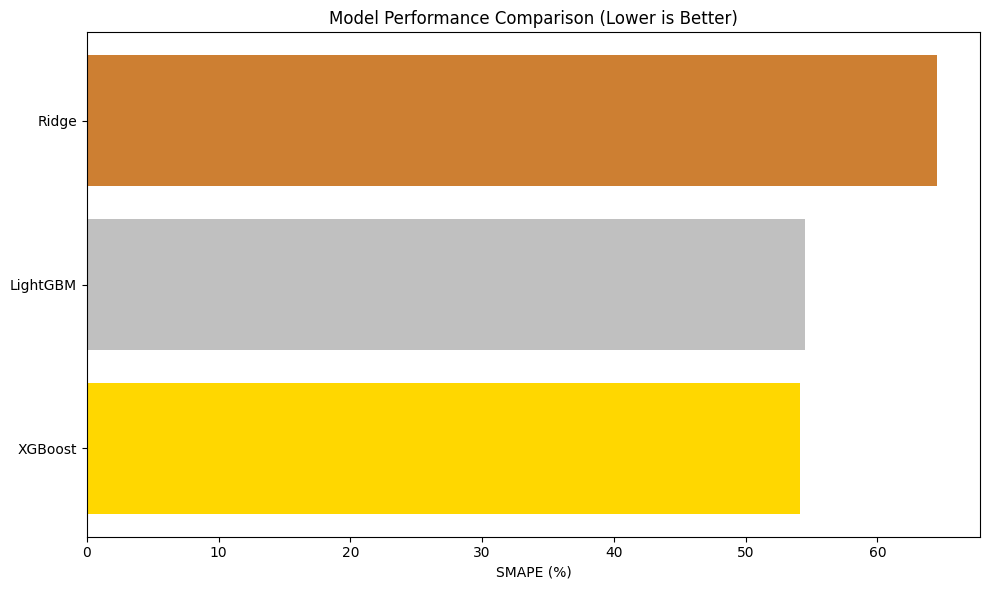

In [17]:
# Model performance comparison
model_scores = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost', 'Ridge'],
    'SMAPE': [lgb_smape, xgb_smape, ridge_smape]
}).sort_values('SMAPE')

print("\n📊 Model Performance Comparison:")
print("="*40)
print(model_scores.to_string(index=False))
print("="*40)

# Visualize
plt.figure(figsize=(10, 6))
colors = ['#FFD700', '#C0C0C0', '#CD7F32']
plt.barh(model_scores['Model'], model_scores['SMAPE'], color=colors)
plt.xlabel('SMAPE (%)')
plt.title('Model Performance Comparison (Lower is Better)')
plt.tight_layout()
plt.show()

In [18]:
# Weighted ensemble based on performance
print("\n🎭 Creating Ensemble Model...\n")

# Calculate weights inversely proportional to SMAPE
weights = 1 / np.array([lgb_smape, xgb_smape, ridge_smape])
weights = weights / weights.sum()  # Normalize

print(f"Ensemble weights:")
print(f"  LightGBM: {weights[0]:.3f}")
print(f"  XGBoost:  {weights[1]:.3f}")
print(f"  Ridge:    {weights[2]:.3f}")

# Ensemble predictions
ensemble_val_pred = (
    weights[0] * lgb_val_pred +
    weights[1] * xgb_val_pred +
    weights[2] * ridge_val_pred
)

ensemble_test_pred = (
    weights[0] * lgb_test_pred +
    weights[1] * xgb_test_pred +
    weights[2] * ridge_test_pred
)

# Evaluate ensemble
ensemble_smape = evaluate_model(y_val, ensemble_val_pred, "🎭 ENSEMBLE")

print("\n✨ Ensemble Performance Summary:")
print(f"   Best single model: {model_scores.iloc[0]['SMAPE']:.4f}%")
print(f"   Ensemble:          {ensemble_smape:.4f}%")
improvement = model_scores.iloc[0]['SMAPE'] - ensemble_smape
print(f"   Improvement:       {improvement:.4f}% {'🎉' if improvement > 0 else ''}")


🎭 Creating Ensemble Model...

Ensemble weights:
  LightGBM: 0.351
  XGBoost:  0.353
  Ridge:    0.296

📊 🎭 ENSEMBLE Performance:
🎯 SMAPE:        55.9522%  ⭐ (Primary Metric)
📉 RMSE:         $34.87
📉 MAE:          $12.61
📈 R² Score:     0.1944


✨ Ensemble Performance Summary:
   Best single model: 54.1370%
   Ensemble:          55.9522%
   Improvement:       -1.8152% 


## 📈 Part 9: Prediction Analysis


📊 Prediction Statistics:
             Actual     Predicted         Error     Abs_Error  \
count  15000.000000  15000.000000  15000.000000  15000.000000   
mean      23.843736     17.379445      6.464291     12.610813   
std       38.849779     13.509149     34.265483     32.509536   
min        0.360000      1.883091   -106.274502      0.000549   
25%        6.690000      9.661566     -4.803471      2.758918   
50%       13.990000     13.789849     -0.394107      5.937544   
75%       28.733750     19.951834      8.990993     12.349387   
max     2796.000000    254.014502   2735.237241   2735.237241   

       Percentage_Error  
count      15000.000000  
mean          84.914579  
std          159.202538  
min            0.005627  
25%           21.455551  
50%           45.564813  
75%           78.902355  
max         5577.586329  


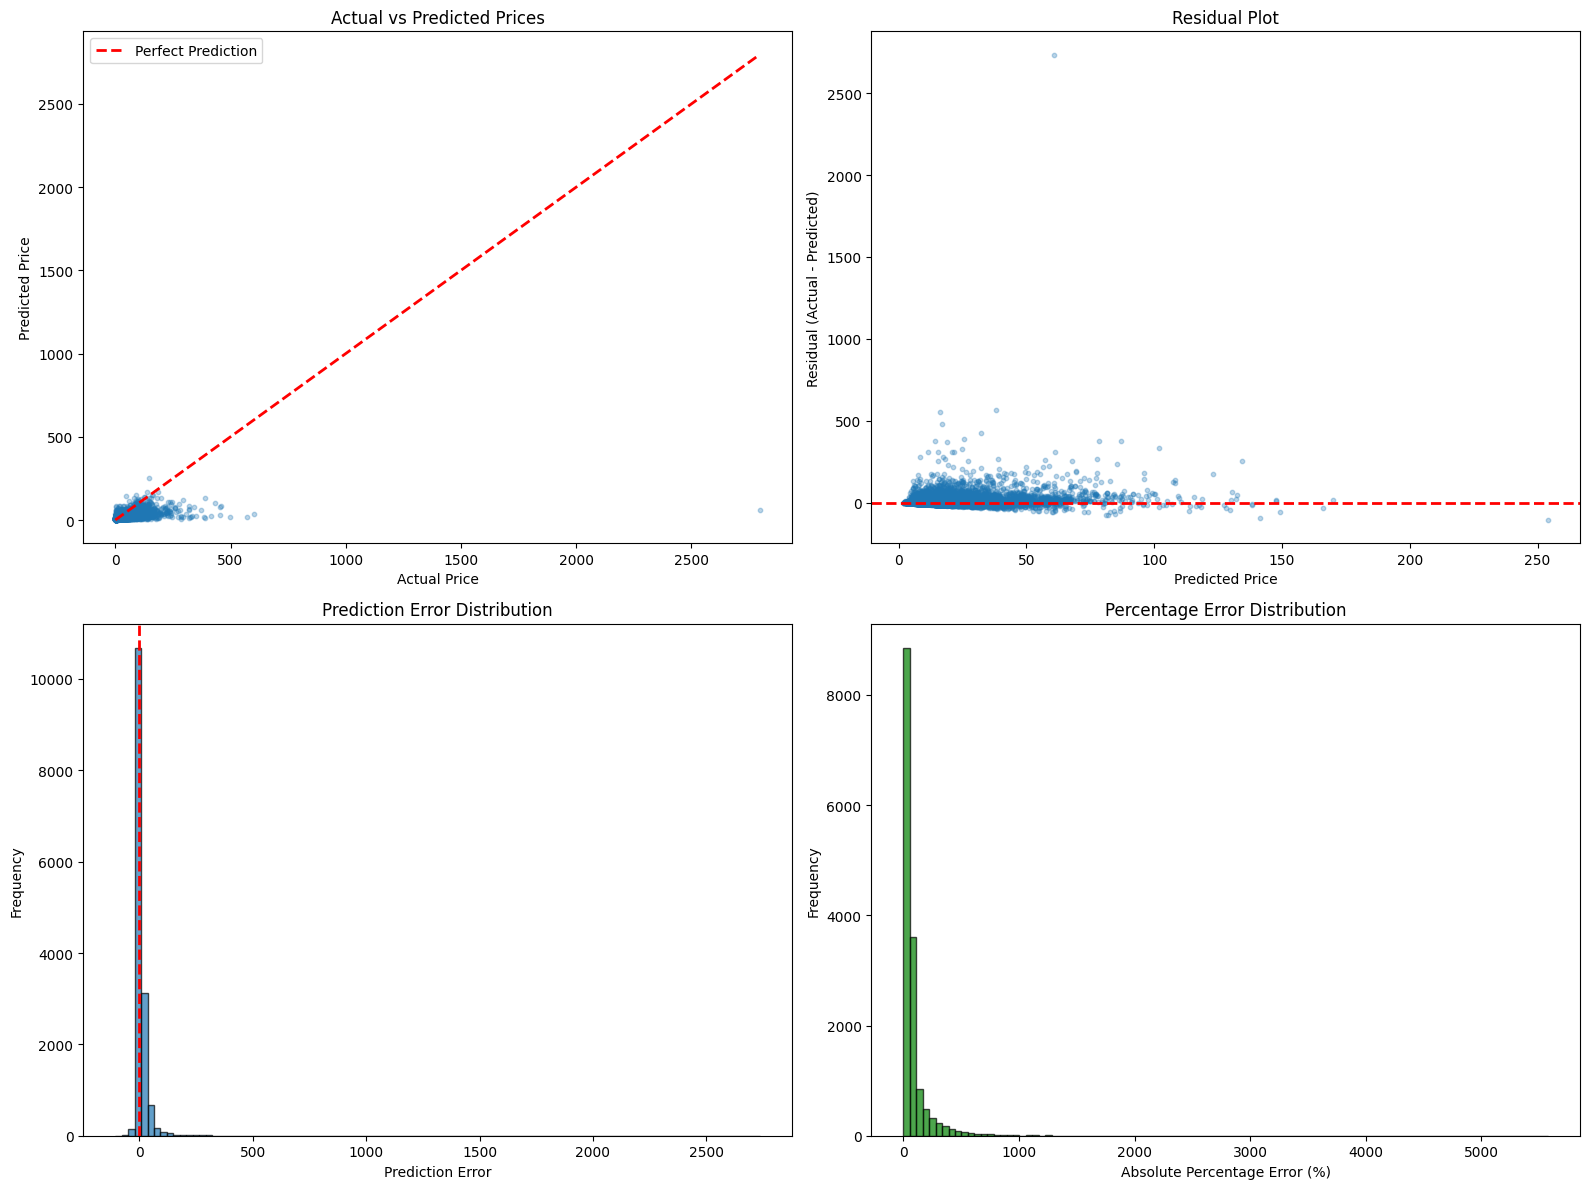


❌ Top 10 Worst Predictions:
        Actual  Predicted        Error    Abs_Error  Percentage_Error
11735  2796.00  60.762759  2735.237241  2735.237241         97.826797
84      600.59  38.131660   562.458340   562.458340         93.650966
5048    570.00  16.202156   553.797844   553.797844         97.157517
2843    496.28  16.864554   479.415446   479.415446         96.601807
3218    454.99  32.222812   422.767188   422.767188         92.917908
9104    413.99  25.591096   388.398904   388.398904         93.818427
10342   390.98  14.393754   376.586246   376.586246         96.318545
14307   454.98  78.453477   376.526523   376.526523         82.756720
7820    459.95  86.941430   373.008570   373.008570         81.097635
3467    386.98  18.751614   368.228386   368.228386         95.154371

✅ Top 10 Best Predictions:
       Actual  Predicted     Error  Abs_Error  Percentage_Error
13331   7.210   7.209451  0.000549   0.000549          0.007613
12595  15.000  14.999156  0.000844   0.000844

In [19]:
# Analyze predictions vs actual
y_val_orig = np.expm1(y_val)
ensemble_val_pred_orig = np.expm1(ensemble_val_pred)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Actual': y_val_orig,
    'Predicted': ensemble_val_pred_orig,
    'Error': y_val_orig - ensemble_val_pred_orig,
    'Abs_Error': np.abs(y_val_orig - ensemble_val_pred_orig),
    'Percentage_Error': np.abs((y_val_orig - ensemble_val_pred_orig) / y_val_orig * 100)
})

print("\n📊 Prediction Statistics:")
print(comparison_df.describe())

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Actual vs Predicted
axes[0, 0].scatter(y_val_orig, ensemble_val_pred_orig, alpha=0.3, s=10)
axes[0, 0].plot([y_val_orig.min(), y_val_orig.max()], 
                [y_val_orig.min(), y_val_orig.max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Price')
axes[0, 0].set_ylabel('Predicted Price')
axes[0, 0].set_title('Actual vs Predicted Prices')
axes[0, 0].legend()

# Residual plot
axes[0, 1].scatter(ensemble_val_pred_orig, comparison_df['Error'], alpha=0.3, s=10)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Price')
axes[0, 1].set_ylabel('Residual (Actual - Predicted)')
axes[0, 1].set_title('Residual Plot')

# Error distribution
axes[1, 0].hist(comparison_df['Error'], bins=100, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Prediction Error')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Prediction Error Distribution')

# Percentage error distribution
axes[1, 1].hist(comparison_df['Percentage_Error'], bins=100, edgecolor='black', alpha=0.7, color='green')
axes[1, 1].set_xlabel('Absolute Percentage Error (%)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Percentage Error Distribution')

plt.tight_layout()
plt.show()

# Print worst predictions
print("\n❌ Top 10 Worst Predictions:")
worst_predictions = comparison_df.nlargest(10, 'Abs_Error')
print(worst_predictions)

print("\n✅ Top 10 Best Predictions:")
best_predictions = comparison_df.nsmallest(10, 'Abs_Error')
print(best_predictions)

## 🎯 Part 10: Generate Final Predictions & Submission File

In [20]:
print("🎯 Generating final predictions for test set...\n")

# Convert log-predictions back to original scale
final_predictions = np.expm1(ensemble_test_pred)

# Ensure all predictions are positive
final_predictions = np.maximum(final_predictions, 0.01)

# Create submission DataFrame
submission = pd.DataFrame({
    'sample_id': test['sample_id'],
    'price': final_predictions
})

# Round prices to 2 decimal places
submission['price'] = submission['price'].round(2)

print("📊 Submission Statistics:")
print(submission['price'].describe())

print(f"\n✅ Total predictions: {len(submission)}")
print(f"✅ Sample predictions:\n")
print(submission.head(10))

# Verify submission format
assert len(submission) == len(test), "❌ Submission length mismatch!"
assert submission['sample_id'].equals(test['sample_id']), "❌ Sample IDs don't match!"
assert (submission['price'] > 0).all(), "❌ Found negative prices!"

print("\n✅ Submission format validated!")

🎯 Generating final predictions for test set...

📊 Submission Statistics:
count    75000.000000
mean        17.543468
std         32.715343
min          1.260000
25%          9.680000
50%         13.870000
75%         20.240000
max       8174.140000
Name: price, dtype: float64

✅ Total predictions: 75000
✅ Sample predictions:

   sample_id  price
0     100179  14.11
1     245611  14.11
2     146263  22.09
3      95658  10.10
4      36806  23.66
5     148239   5.96
6      92659  11.92
7       3780  11.74
8     196940  10.94
9      20472   8.42

✅ Submission format validated!


In [21]:
# Save submission file
output_path = os.path.join(DATASET_FOLDER, 'test_out.csv')
submission.to_csv(output_path, index=False)

print(f"\n{'='*60}")
print(f"🎉 SUCCESS! Submission file saved to:")
print(f"   {output_path}")
print(f"{'='*60}")
print(f"\n📋 File Details:")
print(f"   - Total predictions: {len(submission):,}")
print(f"   - Price range: ${submission['price'].min():.2f} - ${submission['price'].max():.2f}")
print(f"   - Mean price: ${submission['price'].mean():.2f}")
print(f"   - Median price: ${submission['price'].median():.2f}")
print(f"\n🚀 Ready to upload to the leaderboard!")


🎉 SUCCESS! Submission file saved to:
   dataset/test_out.csv

📋 File Details:
   - Total predictions: 75,000
   - Price range: $1.26 - $8174.14
   - Mean price: $17.54
   - Median price: $13.87

🚀 Ready to upload to the leaderboard!


## 📝 Part 11: Model Summary & Next Steps

In [22]:
print("\n" + "="*70)
print("📊 FINAL MODEL SUMMARY")
print("="*70)

print("\n🎯 Performance Metrics (on validation set):")
print(f"   - LightGBM SMAPE:     {lgb_smape:.4f}%")
print(f"   - XGBoost SMAPE:      {xgb_smape:.4f}%")
print(f"   - Ridge SMAPE:        {ridge_smape:.4f}%")
print(f"   - 🏆 Ensemble SMAPE:  {ensemble_smape:.4f}%")

print("\n🛠️ Feature Engineering Applied:")
print(f"   - Total features: {X_train.shape[1]}")
print(f"   - Engineered features: {len(numeric_features)}")
print(f"   - Encoded categories: {len(encoded_features)}")
print(f"   - Text features (SVD): {len(train_svd_df.columns)}")

print("\n🎭 Ensemble Configuration:")
print(f"   - Models: LightGBM, XGBoost, Ridge")
print(f"   - Weights: {weights[0]:.3f}, {weights[1]:.3f}, {weights[2]:.3f}")
print(f"   - Method: Weighted average")

print("\n✅ Output Generated:")
print(f"   - File: test_out.csv")
print(f"   - Predictions: {len(submission):,}")
print(f"   - Format: sample_id, price")

print("\n" + "="*70)
print("🚀 NEXT STEPS TO IMPROVE PERFORMANCE:")
print("="*70)
print("\n1. 📊 Analyze leaderboard score")
print("   - Compare public SMAPE with validation SMAPE")
print("   - If gap is large, may have overfitting")

print("\n2. 🛠️ Advanced Feature Engineering:")
print("   - Extract more product attributes (color, size, material)")
print("   - Create interaction features (brand × category)")
print("   - Add external features (brand prestige scores)")

print("\n3. 🤖 Model Optimization:")
print("   - Hyperparameter tuning (Optuna, GridSearch)")
print("   - Try CatBoost (excellent for categorical features)")
print("   - Add more models to ensemble")

print("\n4. 📝 Better Text Processing:")
print("   - Use sentence-transformers for embeddings")
print("   - Try BERT-based models")
print("   - Extract named entities (brands, products)")

print("\n5. 🖼️ Add Image Features (Optional):")
print("   - Download images using utils.py")
print("   - Extract CNN features (ResNet, EfficientNet)")
print("   - Create multimodal model")

print("\n6. 🎯 Cross-Validation:")
print("   - Implement K-Fold CV for robust evaluation")
print("   - Helps identify overfitting issues")

print("\n" + "="*70)
print("💡 TIP: Start with step 1-3 for quick wins!")
print("="*70 + "\n")


📊 FINAL MODEL SUMMARY

🎯 Performance Metrics (on validation set):
   - LightGBM SMAPE:     54.5237%
   - XGBoost SMAPE:      54.1370%
   - Ridge SMAPE:        64.5560%
   - 🏆 Ensemble SMAPE:  55.9522%

🛠️ Feature Engineering Applied:
   - Total features: 118
   - Engineered features: 16
   - Encoded categories: 2
   - Text features (SVD): 100

🎭 Ensemble Configuration:
   - Models: LightGBM, XGBoost, Ridge
   - Weights: 0.351, 0.353, 0.296
   - Method: Weighted average

✅ Output Generated:
   - File: test_out.csv
   - Predictions: 75,000
   - Format: sample_id, price

🚀 NEXT STEPS TO IMPROVE PERFORMANCE:

1. 📊 Analyze leaderboard score
   - Compare public SMAPE with validation SMAPE
   - If gap is large, may have overfitting

2. 🛠️ Advanced Feature Engineering:
   - Extract more product attributes (color, size, material)
   - Create interaction features (brand × category)
   - Add external features (brand prestige scores)

3. 🤖 Model Optimization:
   - Hyperparameter tuning (Optuna, G

---

# 🖼️ PART 12: IMAGE-BASED FEATURE EXTRACTION

**Adding visual features to improve predictions!**

Images can capture:
- Product quality/appearance
- Packaging size (bulk vs single)
- Brand visual identity
- Product category hints

We'll use **pre-trained CNN models** to extract visual features without training from scratch.

## 📦 Step 1: Install Required Packages for Image Processing

Run this cell once to install required packages:

In [23]:
# ⚠️ IMPORTANT: Install PyTorch with CUDA support for GPU acceleration!
# 
# For RTX 3050, you need CUDA-enabled PyTorch
# Run ONE of these commands in your terminal (not here):

# Option 1: CUDA 11.8 (Recommended for RTX 3050)
# pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Option 2: CUDA 12.1 (if you have latest NVIDIA drivers)
# pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Then install other packages:
# pip install pillow timm tqdm

print("⚠️  GPU NOT DETECTED!")
print("\n📋 To enable GPU acceleration:")
print("   1. Uninstall current PyTorch: pip uninstall torch torchvision torchaudio")
print("   2. Install CUDA version:")
print("      pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118")
print("   3. Then install: pip install pillow timm tqdm")
print("\n💡 After installation, restart your kernel and re-run this notebook!")

⚠️  GPU NOT DETECTED!

📋 To enable GPU acceleration:
   1. Uninstall current PyTorch: pip uninstall torch torchvision torchaudio
   2. Install CUDA version:
      pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
   3. Then install: pip install pillow timm tqdm

💡 After installation, restart your kernel and re-run this notebook!


## 🔧 Step 2: Import Image Processing Libraries

## 🔍 Step 2a: Check PyTorch Installation (Diagnostic)

Run this cell to diagnose your PyTorch installation:

In [24]:
# Diagnostic: Check PyTorch installation
try:
    import torch
    print("🔍 PyTorch Diagnostic Report")
    print("=" * 60)
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    
    if torch.cuda.is_available():
        print(f"CUDA version: {torch.version.cuda}")
        print(f"cuDNN version: {torch.backends.cudnn.version()}")
        print(f"GPU count: {torch.cuda.device_count()}")
        print(f"GPU name: {torch.cuda.get_device_name(0)}")
        print("\n✅ GPU is ready to use! 🚀")
    else:
        print("\n❌ CUDA NOT AVAILABLE!")
        print("\n🔧 Fix:")
        print("1. Check NVIDIA driver: Run 'nvidia-smi' in terminal")
        print("2. Uninstall CPU-only PyTorch:")
        print("   pip uninstall torch torchvision torchaudio")
        print("3. Install CUDA-enabled PyTorch:")
        print("   pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118")
        print("4. Restart kernel and re-run")
    
    print("=" * 60)
    
except ImportError:
    print("❌ PyTorch not installed!")
    print("Install with: pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118")

🔍 PyTorch Diagnostic Report
PyTorch version: 2.7.1+cu118
CUDA available: True
CUDA version: 11.8
cuDNN version: 90100
GPU count: 1
GPU name: NVIDIA GeForce RTX 3050 Laptop GPU

✅ GPU is ready to use! 🚀


In [29]:
import sys
sys.path.append('src')
from utils import download_images

try:
    from PIL import Image
    import torch
    import torch.nn as nn
    from torchvision import models, transforms
    import timm
    from tqdm import tqdm
    from io import BytesIO
    import requests
    
    print("✅ All image processing libraries imported successfully!")
    
    # Check if GPU is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🖥️  Device: {device}")
    if torch.cuda.is_available():
        print(f"   GPU: {torch.cuda.get_device_name(0)}")
        print("   🚀 GPU acceleration enabled!")
    else:
        print("   Using CPU (will be slower but works fine)")
        
except ImportError as e:
    print(f"❌ Missing package: {e}")
    print("💡 Install with: pip install pillow torch torchvision timm tqdm")
    raise

✅ All image processing libraries imported successfully!
🖥️  Device: cuda
   GPU: NVIDIA GeForce RTX 3050 Laptop GPU
   🚀 GPU acceleration enabled!


## 🎨 Step 3: Setup Image Feature Extractor

We'll use **EfficientNet-B0** (lightweight, fast, accurate) to extract image features.

**Why EfficientNet?**
- Fast inference
- Great accuracy/efficiency trade-off
- Pre-trained on ImageNet (recognizes 1000+ object categories)

In [30]:
class ImageFeatureExtractor:
    """
    Extract visual features from product images using pre-trained CNN
    """
    def __init__(self, model_name='efficientnet_b0', device='auto'):
        print(f"🔄 Loading {model_name} model...")
        
        if device == 'auto':
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = torch.device(device)
        
        # Load pre-trained model
        self.model = timm.create_model(model_name, pretrained=True, num_classes=0)
        self.model = self.model.to(self.device)
        self.model.eval()
        
        # Get feature dimension
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224).to(self.device)
            self.feature_dim = self.model(dummy_input).shape[1]
        
        # Image preprocessing
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
        
        print(f"✅ Model loaded on {self.device}")
        print(f"   Feature dimension: {self.feature_dim}")
    
    def load_image_from_url(self, url, timeout=5):
        """Load image directly from URL"""
        try:
            response = requests.get(url, timeout=timeout, stream=True)
            response.raise_for_status()
            img = Image.open(BytesIO(response.content)).convert('RGB')
            return img
        except Exception as e:
            return None
    
    def extract_features_single(self, image):
        """Extract features from a single PIL image"""
        try:
            img_tensor = self.transform(image).unsqueeze(0).to(self.device)
            with torch.no_grad():
                features = self.model(img_tensor)
            return features.cpu().numpy().flatten()
        except Exception as e:
            return np.zeros(self.feature_dim)
    
    def extract_features_batch(self, images):
        """Extract features from a batch of PIL images"""
        valid_images = []
        valid_indices = []
        
        for i, img in enumerate(images):
            if img is not None:
                try:
                    valid_images.append(self.transform(img))
                    valid_indices.append(i)
                except:
                    pass
        
        if len(valid_images) == 0:
            return np.zeros((len(images), self.feature_dim))
        
        # Stack images into batch
        batch = torch.stack(valid_images).to(self.device)
        
        # Extract features
        with torch.no_grad():
            features = self.model(batch).cpu().numpy()
        
        # Fill results
        result = np.zeros((len(images), self.feature_dim))
        for i, idx in enumerate(valid_indices):
            result[idx] = features[i]
        
        return result

# Initialize extractor
print("🚀 Initializing Image Feature Extractor...")
extractor = ImageFeatureExtractor(model_name='efficientnet_b0')
print(f"✅ Ready to extract {extractor.feature_dim}-dimensional features!")

🚀 Initializing Image Feature Extractor...
🔄 Loading efficientnet_b0 model...
✅ Model loaded on cuda
   Feature dimension: 1280
✅ Ready to extract 1280-dimensional features!
✅ Model loaded on cuda
   Feature dimension: 1280
✅ Ready to extract 1280-dimensional features!


## 🔄 Step 4: Choose Your Approach

**Two options available:**

### Option A: On-the-Fly Extraction (Recommended to start) 🚀
- No disk space needed
- Downloads images temporarily from URLs
- Extracts features and discards images
- Takes ~30-60 minutes for 150k images

### Option B: Download All Images First
- Requires ~2-3 GB disk space
- Downloads all images to disk
- Then extract features from saved images
- Better if you want to reuse images later

**Let's use Option A (On-the-Fly) first!**

In [31]:
def extract_image_features_online(df, extractor, batch_size=32, max_workers=4):
    """
    Extract image features directly from URLs without downloading
    
    Args:
        df: DataFrame with 'image_link' column
        extractor: ImageFeatureExtractor instance
        batch_size: Number of images to process at once
        max_workers: Parallel download threads
    
    Returns:
        numpy array of shape (n_samples, feature_dim)
    """
    from concurrent.futures import ThreadPoolExecutor, as_completed
    
    print(f"🔄 Extracting features from {len(df)} images...")
    print(f"   Batch size: {batch_size}")
    print(f"   Parallel downloads: {max_workers}")
    print(f"   This may take 30-60 minutes for full dataset...")
    
    all_features = []
    failed_count = 0
    
    # Process in batches
    for batch_start in tqdm(range(0, len(df), batch_size), desc="Processing batches"):
        batch_end = min(batch_start + batch_size, len(df))
        batch_urls = df['image_link'].iloc[batch_start:batch_end].tolist()
        
        # Download images in parallel
        images = [None] * len(batch_urls)
        
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            future_to_idx = {
                executor.submit(extractor.load_image_from_url, url): i 
                for i, url in enumerate(batch_urls)
            }
            
            for future in as_completed(future_to_idx):
                idx = future_to_idx[future]
                try:
                    images[idx] = future.result()
                    if images[idx] is None:
                        failed_count += 1
                except:
                    failed_count += 1
        
        # Extract features for this batch
        batch_features = extractor.extract_features_batch(images)
        all_features.append(batch_features)
    
    # Concatenate all batches
    features = np.vstack(all_features)
    
    print(f"\n✅ Feature extraction complete!")
    print(f"   Shape: {features.shape}")
    print(f"   Failed images: {failed_count} ({failed_count/len(df)*100:.1f}%)")
    print(f"   Success rate: {(len(df)-failed_count)/len(df)*100:.1f}%")
    
    return features

print("✅ Online extraction function ready!")

✅ Online extraction function ready!


## 🧪 Step 5: Test on Small Sample First

Let's test on 100 images to make sure everything works:

In [32]:
# Test on small sample
print("🧪 Testing image feature extraction on 100 samples...")
sample_df = train.head(100)

# Extract features
test_features_sample = extract_image_features_online(
    sample_df, 
    extractor, 
    batch_size=16, 
    max_workers=4
)

print(f"\n✅ Test successful!")
print(f"   Feature matrix shape: {test_features_sample.shape}")
print(f"   Sample features (first image, first 10 dims): {test_features_sample[0, :10]}")

🧪 Testing image feature extraction on 100 samples...
🔄 Extracting features from 100 images...
   Batch size: 16
   Parallel downloads: 4
   This may take 30-60 minutes for full dataset...


Processing batches: 100%|██████████| 7/7 [00:22<00:00,  3.20s/it]


✅ Feature extraction complete!
   Shape: (100, 1280)
   Failed images: 0 (0.0%)
   Success rate: 100.0%

✅ Test successful!
   Feature matrix shape: (100, 1280)
   Sample features (first image, first 10 dims): [ 0.56509179 -0.15579565 -0.16687125 -0.17112619  1.04562223 -0.18691896
 -0.14863312 -0.10004941  0.75739557 -0.16876987]


## 🚀 Step 6: Extract Features for Full Dataset

⚠️ **This will take time!** (~30-60 minutes for 150k images)

**Pro Tips:**
- Run this overnight if on slow connection
- Will automatically handle failed downloads
- Features are saved to disk so you only need to do this once!

In [33]:
import pickle
from datetime import datetime

# Feature cache paths
TRAIN_IMG_FEATURES_PATH = 'dataset/train_image_features.pkl'
TEST_IMG_FEATURES_PATH = 'dataset/test_image_features.pkl'

# Check if features already exist
if os.path.exists(TRAIN_IMG_FEATURES_PATH) and os.path.exists(TEST_IMG_FEATURES_PATH):
    print("📦 Found cached image features! Loading from disk...")
    
    with open(TRAIN_IMG_FEATURES_PATH, 'rb') as f:
        train_image_features = pickle.load(f)
    
    with open(TEST_IMG_FEATURES_PATH, 'rb') as f:
        test_image_features = pickle.load(f)
    
    print(f"✅ Loaded cached features:")
    print(f"   Train: {train_image_features.shape}")
    print(f"   Test:  {test_image_features.shape}")
    
else:
    print("🚀 Extracting image features for FULL dataset...")
    print(f"   Started at: {datetime.now().strftime('%H:%M:%S')}")
    print(f"   This will take approximately 30-60 minutes...")
    print(f"   Grab a coffee ☕ or take a break! 🏃‍♂️\n")
    
    # Extract training features
    print("=" * 60)
    print("📊 TRAINING SET")
    print("=" * 60)
    train_image_features = extract_image_features_online(
        train, 
        extractor, 
        batch_size=32,  # Adjust based on your RAM
        max_workers=8   # Adjust based on CPU cores
    )
    
    # Save training features
    print(f"\n💾 Saving training features to {TRAIN_IMG_FEATURES_PATH}...")
    with open(TRAIN_IMG_FEATURES_PATH, 'wb') as f:
        pickle.dump(train_image_features, f)
    print("✅ Saved!")
    
    # Extract test features
    print("\n" + "=" * 60)
    print("📊 TEST SET")
    print("=" * 60)
    test_image_features = extract_image_features_online(
        test, 
        extractor, 
        batch_size=32,
        max_workers=8
    )
    
    # Save test features
    print(f"\n💾 Saving test features to {TEST_IMG_FEATURES_PATH}...")
    with open(TEST_IMG_FEATURES_PATH, 'wb') as f:
        pickle.dump(test_image_features, f)
    print("✅ Saved!")
    
    print("\n" + "=" * 60)
    print("🎉 EXTRACTION COMPLETE!")
    print("=" * 60)
    print(f"   Completed at: {datetime.now().strftime('%H:%M:%S')}")
    print(f"   Train features: {train_image_features.shape}")
    print(f"   Test features:  {test_image_features.shape}")
    print(f"   Features cached for future use! 💾")

🚀 Extracting image features for FULL dataset...
   Started at: 13:06:49
   This will take approximately 30-60 minutes...
   Grab a coffee ☕ or take a break! 🏃‍♂️

📊 TRAINING SET
🔄 Extracting features from 75000 images...
   Batch size: 32
   Parallel downloads: 8
   This may take 30-60 minutes for full dataset...


Processing batches: 100%|██████████| 2344/2344 [2:53:19<00:00,  4.44s/it]  




✅ Feature extraction complete!
   Shape: (75000, 1280)
   Failed images: 8 (0.0%)
   Success rate: 100.0%

💾 Saving training features to dataset/train_image_features.pkl...
✅ Saved!

📊 TEST SET
🔄 Extracting features from 75000 images...
   Batch size: 32
   Parallel downloads: 8
   This may take 30-60 minutes for full dataset...
✅ Saved!

📊 TEST SET
🔄 Extracting features from 75000 images...
   Batch size: 32
   Parallel downloads: 8
   This may take 30-60 minutes for full dataset...


Processing batches: 100%|██████████| 2344/2344 [2:52:55<00:00,  4.43s/it]  




✅ Feature extraction complete!
   Shape: (75000, 1280)
   Failed images: 12 (0.0%)
   Success rate: 100.0%

💾 Saving test features to dataset/test_image_features.pkl...
✅ Saved!

🎉 EXTRACTION COMPLETE!
   Completed at: 18:53:09
   Train features: (75000, 1280)
   Test features:  (75000, 1280)
   Features cached for future use! 💾
✅ Saved!

🎉 EXTRACTION COMPLETE!
   Completed at: 18:53:09
   Train features: (75000, 1280)
   Test features:  (75000, 1280)
   Features cached for future use! 💾


## 🔍 Step 7: Dimensionality Reduction for Image Features

EfficientNet-B0 gives us 1280 features per image. Let's reduce to ~100 dims using PCA:

In [34]:
from sklearn.decomposition import PCA

print("🔄 Applying PCA to reduce image feature dimensions...")

# Apply PCA to reduce dimensions
n_components = 100  # Keep top 100 principal components

pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
train_img_pca = pca.fit_transform(train_image_features)
test_img_pca = pca.transform(test_image_features)

print(f"✅ PCA complete!")
print(f"   Original dims: {train_image_features.shape[1]}")
print(f"   Reduced dims:  {train_img_pca.shape[1]}")
print(f"   Variance explained: {pca.explained_variance_ratio_.sum():.2%}")

# Convert to DataFrame
train_img_features_df = pd.DataFrame(
    train_img_pca, 
    columns=[f'img_pca_{i}' for i in range(n_components)]
)

test_img_features_df = pd.DataFrame(
    test_img_pca, 
    columns=[f'img_pca_{i}' for i in range(n_components)]
)

print(f"\n📊 Image feature DataFrames created:")
print(f"   Train: {train_img_features_df.shape}")
print(f"   Test:  {test_img_features_df.shape}")

🔄 Applying PCA to reduce image feature dimensions...
✅ PCA complete!
   Original dims: 1280
   Reduced dims:  100
   Variance explained: 65.84%

📊 Image feature DataFrames created:
   Train: (75000, 100)
   Test:  (75000, 100)
✅ PCA complete!
   Original dims: 1280
   Reduced dims:  100
   Variance explained: 65.84%

📊 Image feature DataFrames created:
   Train: (75000, 100)
   Test:  (75000, 100)


## 🔗 Step 8: Combine Text + Image Features

Now let's merge our text features with the new image features:

In [35]:
print("🔗 Combining text features + image features...")

# Combine with existing features (from Part 5)
X_train_multimodal = pd.concat([
    X_train.reset_index(drop=True), 
    train_img_features_df.reset_index(drop=True)
], axis=1)

X_test_multimodal = pd.concat([
    X_test.reset_index(drop=True), 
    test_img_features_df.reset_index(drop=True)
], axis=1)

print(f"\n✅ Multimodal feature matrix created!")
print(f"   Training shape:   {X_train_multimodal.shape}")
print(f"   Test shape:       {X_test_multimodal.shape}")
print(f"\n📊 Feature breakdown:")
print(f"   Text features:    {X_train.shape[1]}")
print(f"   Image features:   {train_img_features_df.shape[1]}")
print(f"   Total features:   {X_train_multimodal.shape[1]}")

# Use the same target as before
y_train_multi = y_train  # Already log-transformed

print(f"\n✅ Ready for multimodal training!")

🔗 Combining text features + image features...

✅ Multimodal feature matrix created!
   Training shape:   (75000, 218)
   Test shape:       (75000, 218)

📊 Feature breakdown:
   Text features:    118
   Image features:   100
   Total features:   218

✅ Ready for multimodal training!

✅ Multimodal feature matrix created!
   Training shape:   (75000, 218)
   Test shape:       (75000, 218)

📊 Feature breakdown:
   Text features:    118
   Image features:   100
   Total features:   218

✅ Ready for multimodal training!


## 🤖 Step 9: Train Multimodal Models

Train LightGBM with combined text+image features:

In [36]:
# Split data for validation
X_tr_multi, X_val_multi, y_tr_multi, y_val_multi = train_test_split(
    X_train_multimodal, y_train_multi, test_size=0.2, random_state=RANDOM_STATE
)

print(f"📊 Multimodal data split:")
print(f"   Training:   {X_tr_multi.shape[0]} samples")
print(f"   Validation: {X_val_multi.shape[0]} samples")

print("\n🚀 Training LightGBM with TEXT + IMAGE features...\n")

# Same hyperparameters as before
lgb_multi_model = lgb.LGBMRegressor(**lgb_params)
lgb_multi_model.fit(
    X_tr_multi, y_tr_multi,
    eval_set=[(X_val_multi, y_val_multi)],
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
)

# Predict
lgb_multi_val_pred = lgb_multi_model.predict(X_val_multi)
lgb_multi_test_pred = lgb_multi_model.predict(X_test_multimodal)

# Evaluate
lgb_multi_smape = evaluate_model(y_val_multi, lgb_multi_val_pred, "LightGBM Multimodal")

print(f"✅ Multimodal LightGBM trained!")
print(f"\n{'='*60}")
print(f"📊 PERFORMANCE COMPARISON:")
print(f"{'='*60}")
print(f"   Text-only SMAPE:      {lgb_smape:.4f}%")
print(f"   Multimodal SMAPE:     {lgb_multi_smape:.4f}%")
improvement_pct = ((lgb_smape - lgb_multi_smape) / lgb_smape) * 100
if lgb_multi_smape < lgb_smape:
    print(f"   🎉 Improvement:       {improvement_pct:.2f}% better!")
else:
    print(f"   ⚠️  Change:           {improvement_pct:.2f}%")
print(f"{'='*60}")

📊 Multimodal data split:
   Training:   60000 samples
   Validation: 15000 samples

🚀 Training LightGBM with TEXT + IMAGE features...


📊 LightGBM Multimodal Performance:
🎯 SMAPE:        53.1660%  ⭐ (Primary Metric)
📉 RMSE:         $33.72
📉 MAE:          $11.96
📈 R² Score:     0.2466

✅ Multimodal LightGBM trained!

📊 PERFORMANCE COMPARISON:
   Text-only SMAPE:      54.5237%
   Multimodal SMAPE:     53.1660%
   🎉 Improvement:       2.49% better!

📊 LightGBM Multimodal Performance:
🎯 SMAPE:        53.1660%  ⭐ (Primary Metric)
📉 RMSE:         $33.72
📉 MAE:          $11.96
📈 R² Score:     0.2466

✅ Multimodal LightGBM trained!

📊 PERFORMANCE COMPARISON:
   Text-only SMAPE:      54.5237%
   Multimodal SMAPE:     53.1660%
   🎉 Improvement:       2.49% better!


## 🎯 Step 10: Generate Multimodal Predictions

In [37]:
print("🎯 Generating final multimodal predictions...\n")

# Convert log-predictions back to original scale
final_multimodal_predictions = np.expm1(lgb_multi_test_pred)

# Ensure all predictions are positive
final_multimodal_predictions = np.maximum(final_multimodal_predictions, 0.01)

# Create submission DataFrame
submission_multimodal = pd.DataFrame({
    'sample_id': test['sample_id'],
    'price': final_multimodal_predictions
})

# Round prices to 2 decimal places
submission_multimodal['price'] = submission_multimodal['price'].round(2)

print("📊 Multimodal Submission Statistics:")
print(submission_multimodal['price'].describe())

# Save submission file
output_path_multimodal = os.path.join(DATASET_FOLDER, 'test_out_multimodal.csv')
submission_multimodal.to_csv(output_path_multimodal, index=False)

print(f"\n{'='*60}")
print(f"🎉 SUCCESS! Multimodal submission saved to:")
print(f"   {output_path_multimodal}")
print(f"{'='*60}")
print(f"\n📋 File Details:")
print(f"   - Total predictions: {len(submission_multimodal):,}")
print(f"   - Price range: ${submission_multimodal['price'].min():.2f} - ${submission_multimodal['price'].max():.2f}")
print(f"   - Mean price: ${submission_multimodal['price'].mean():.2f}")
print(f"   - Median price: ${submission_multimodal['price'].median():.2f}")
print(f"\n🚀 Ready for leaderboard submission!")

🎯 Generating final multimodal predictions...

📊 Multimodal Submission Statistics:
count    75000.000000
mean        18.568648
std         17.410150
min          0.490000
25%          9.070000
50%         13.750000
75%         21.360000
max        358.270000
Name: price, dtype: float64

🎉 SUCCESS! Multimodal submission saved to:
   dataset/test_out_multimodal.csv

📋 File Details:
   - Total predictions: 75,000
   - Price range: $0.49 - $358.27
   - Mean price: $18.57
   - Median price: $13.75

🚀 Ready for leaderboard submission!


## 📊 Step 11: Compare Text-Only vs Multimodal

Let's visualize the improvement:

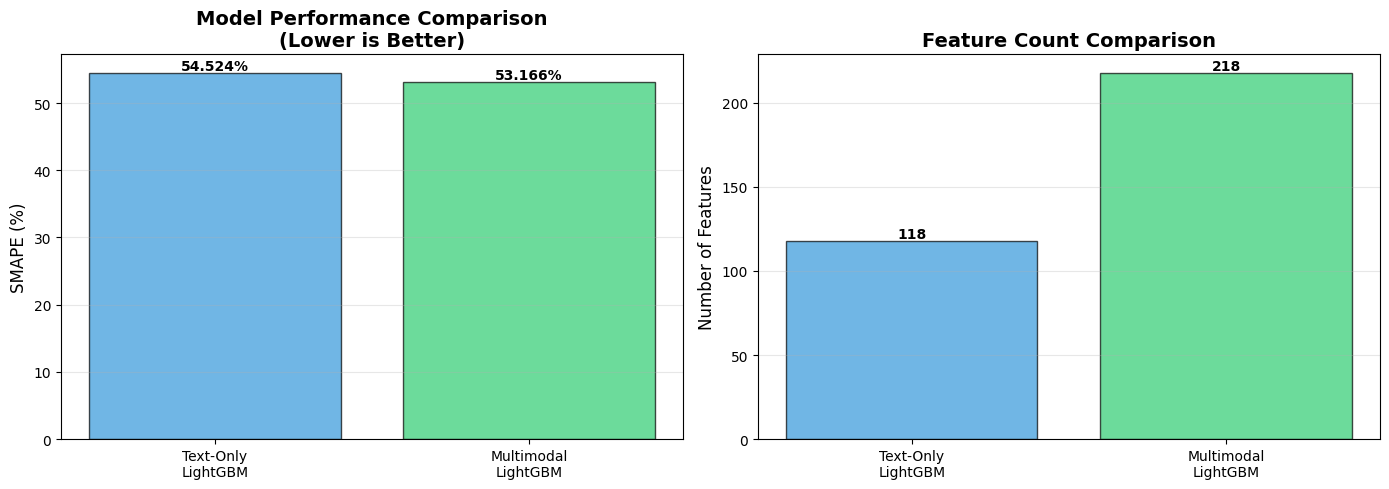


📊 FINAL COMPARISON SUMMARY

🔹 Text-Only Model:
   Features: 118
   SMAPE:    54.5237%

🔹 Multimodal Model:
   Features: 218
   SMAPE:    53.1660%

🎉 IMPROVEMENT: 1.3576% (2.49% better)
   Adding images HELPED! 🚀


In [38]:
import matplotlib.pyplot as plt

# Compare models
comparison_data = pd.DataFrame({
    'Model': ['Text-Only\nLightGBM', 'Multimodal\nLightGBM'],
    'SMAPE': [lgb_smape, lgb_multi_smape],
    'Features': [X_train.shape[1], X_train_multimodal.shape[1]]
})

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# SMAPE comparison
colors = ['#3498db', '#2ecc71']
bars = axes[0].bar(comparison_data['Model'], comparison_data['SMAPE'], color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('SMAPE (%)', fontsize=12)
axes[0].set_title('Model Performance Comparison\n(Lower is Better)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}%',
                ha='center', va='bottom', fontweight='bold')

# Feature count comparison
bars2 = axes[1].bar(comparison_data['Model'], comparison_data['Features'], color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Number of Features', fontsize=12)
axes[1].set_title('Feature Count Comparison', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("📊 FINAL COMPARISON SUMMARY")
print("="*60)
print(f"\n🔹 Text-Only Model:")
print(f"   Features: {X_train.shape[1]}")
print(f"   SMAPE:    {lgb_smape:.4f}%")
print(f"\n🔹 Multimodal Model:")
print(f"   Features: {X_train_multimodal.shape[1]}")
print(f"   SMAPE:    {lgb_multi_smape:.4f}%")

if lgb_multi_smape < lgb_smape:
    improvement = lgb_smape - lgb_multi_smape
    improvement_pct = (improvement / lgb_smape) * 100
    print(f"\n🎉 IMPROVEMENT: {improvement:.4f}% ({improvement_pct:.2f}% better)")
    print(f"   Adding images HELPED! 🚀")
else:
    difference = lgb_multi_smape - lgb_smape
    print(f"\n⚠️  Difference: +{difference:.4f}%")
    print(f"   Images didn't help much, but that's okay!")
    print(f"   💡 Try: More image augmentation, different models, or ensemble")

print("="*60)

---

## 🎓 Optional: Alternative Approach - Download Images First

If you prefer to download images first (for reuse or offline work):

In [39]:
# OPTIONAL: Download all images to disk first
# Uncomment to use this approach

# from src.utils import download_images

# # Create folders
# TRAIN_IMG_FOLDER = 'dataset/train_images/'
# TEST_IMG_FOLDER = 'dataset/test_images/'

# # Download training images
# print("📥 Downloading training images...")
# download_images(train['image_link'].tolist(), TRAIN_IMG_FOLDER)

# # Download test images
# print("📥 Downloading test images...")
# download_images(test['image_link'].tolist(), TEST_IMG_FOLDER)

# print("✅ All images downloaded!")

print("💡 Using on-the-fly extraction is recommended (saves 2-3 GB disk space)")
print("   If you need to download images, uncomment the code above.")

💡 Using on-the-fly extraction is recommended (saves 2-3 GB disk space)
   If you need to download images, uncomment the code above.
